# Bayesian Linear Regression
In this notebook, the Bayesian linear regression is implemented using the below tutorials from scratch.

1) https://towardsdatascience.com/bayesian-statistics-overview-and-your-first-bayesian-linear-regression-model-ba566676c5a7
2) https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html
3) https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50
4) https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7


This notebook requires using the package *pym3* which was installed through the instructions provided:
https://github.com/pymc-devs/pymc/wiki/Installation-Guide-(MacOS)

1) conda create -c conda-forge -n pymc3_env python=3.9 pymc3 theano-pymc mkl mkl-service
2) conda activate pymc3_env
3) conda deactivate

In [46]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import pymc3 as pm    # montecarlo package for python
import arviz as az   # package for analysis of bayesian models
import seaborn as sns

## Read the data

In [14]:
data = pd.read_csv('AB_NYC_2019.csv')

# Remove data with price zero
data = data[data['price']!=0].reset_index(drop=True)
# neigborhoods in NYC:

airbnb_summary_1 = data.groupby(['neighbourhood_group', 'neighbourhood'], as_index=False).agg({'room_type': 'count'}).rename(columns={'room_type': 'num_rooms'})
airbnb_summary_1.sort_values(['num_rooms'], ascending=False, inplace=True) 
airbnb_summary_2 = airbnb_summary_1.groupby(['neighbourhood_group']).agg({'num_rooms': 'sum'})
airbnb_summary_3 = data.pivot_table(index=['neighbourhood_group'], columns=['room_type'], values=['price'], aggfunc=['count', 'mean'])
# consider only entire home/apt types
data = data[data['room_type']=='Entire home/apt'].reset_index(drop=True)
data_ML_X = data[['neighbourhood_group', 'neighbourhood', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']].copy()
data_ML_X.head(5)

# Let's consider only 5 neighborhoods
filter = (data['neighbourhood_group']=='Manhattan') & (data['neighbourhood'].isin(['Midtown', 'East Harlem', 'Chinatown', 'Upper West Side', 'NoHo']))
data_ML_X = data_ML_X[filter].reset_index(drop=True)
data_ML_X.drop(columns=['neighbourhood_group'], inplace=True)

data_ML_y = data[filter]['price'].copy().reset_index(drop=True)
data_ML_X = data_ML_X.fillna(0)

# one hot encoding
data_ML_X = pd.get_dummies(data_ML_X)

# fixing the whitespace in the column name:
cols = data_ML_X.columns.tolist()
cols_new = []

for c in cols:
    if ' ' in c:
        cl = c.replace(' ', '_') 
        cols_new.append(cl)
    else:
        cols_new.append(c)

data_ML_X.columns = cols_new
cols = data_ML_X.columns.tolist()
data_ML_X.head(5)

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,neighbourhood_Chinatown,neighbourhood_East_Harlem,neighbourhood_Midtown,neighbourhood_NoHo,neighbourhood_Upper_West_Side
0,1,45,0.38,2,0,0,1,0,0
1,10,9,0.10,1,0,1,0,0,0
2,1,160,1.33,4,1,0,0,0,0
3,5,53,0.43,1,0,0,0,0,1
4,7,0,0.00,2,0,1,0,0,0


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def standardize_X(df, cols_to_standardize, use_fitted_scalar=None):
    x1 = df[cols_to_standardize]
    if use_fitted_scalar == None:
        scalar = StandardScaler()
        scaled_x1 = scalar.fit_transform(x1)
    else:
        scalar = use_fitted_scalar
        scaled_x1 = scalar.transform(x1)
    scaled_x1 = pd.DataFrame(scaled_x1, columns=cols_to_standardize)

    cols_not_to_standardize = [x for x in df.columns if x not in cols_to_standardize]
    x2 = df[cols_not_to_standardize]


    return scalar, pd.concat([scaled_x1, x2], axis=1)


# normalize X:
cols_to_standardize = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
                      # note: standardizing can make the categorical values too small
                      #       which will make their coefficients very large while training 
scalar_X, data_scaled_X = standardize_X(data_ML_X, cols_to_standardize)

# normalize y: 
scalar_y  = StandardScaler()
data_scaled_y = scalar_y.fit_transform(np.array(data_ML_y).reshape(-1,1))
data_scaled_y = pd.DataFrame(data_scaled_y, columns=['price'])

## Create the test set

In [23]:
test_set = pd.DataFrame(columns=cols)
neighbourhood = ['neighbourhood_Midtown', 'neighbourhood_East_Harlem', 'neighbourhood_Chinatown', 'neighbourhood_Upper_West_Side', 'neighbourhood_NoHo']

for i in range(5):
    inp = np.zeros(len(cols))
    np.put(inp, [0,3], 1)
    test_set.loc[i] = inp
    test_set.at[i, neighbourhood[i]] = 1
    


_, test_set_scaled = standardize_X(test_set, cols_to_standardize, scalar_X)

## Bayesian rules

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

1) $P(A|B)$ -> Posterior
2) $P(B|A)$ -> Likelihood
3) $P(A)$ -> Prior
4) $P(B)$ -> Evidence

## Linear Regression

$y = \beta^{T}X + \epsilon$

## Bayes Linear Regression

$P(\beta|X,y) = \frac{P(X,y|\beta)P(\beta)}{P(X,y)}$
since the evidence term is intractable

$P(\beta|X,y) \enspace \propto \enspace P(X,y|\beta)P(\beta)$

if: 
<br>
$\beta \sim Unif(0,1)$
<br>
then:
<br>
$y = N(\beta^{T}X + \epsilon, \sigma^{2} )$

In [18]:
basic_model = pm.Model()

with basic_model:
    # Prior distribution
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 9)
    epsilon = pm.Normal("epsilon", mu = 0, sigma = 10)
    sigma = pm.HalfNormal("sigma", sigma = 1)
    
        # Expected value of outcome
    mu = epsilon + beta*data_scaled_X

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data_scaled_y)

In [19]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, epsilon, beta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 28 seconds.


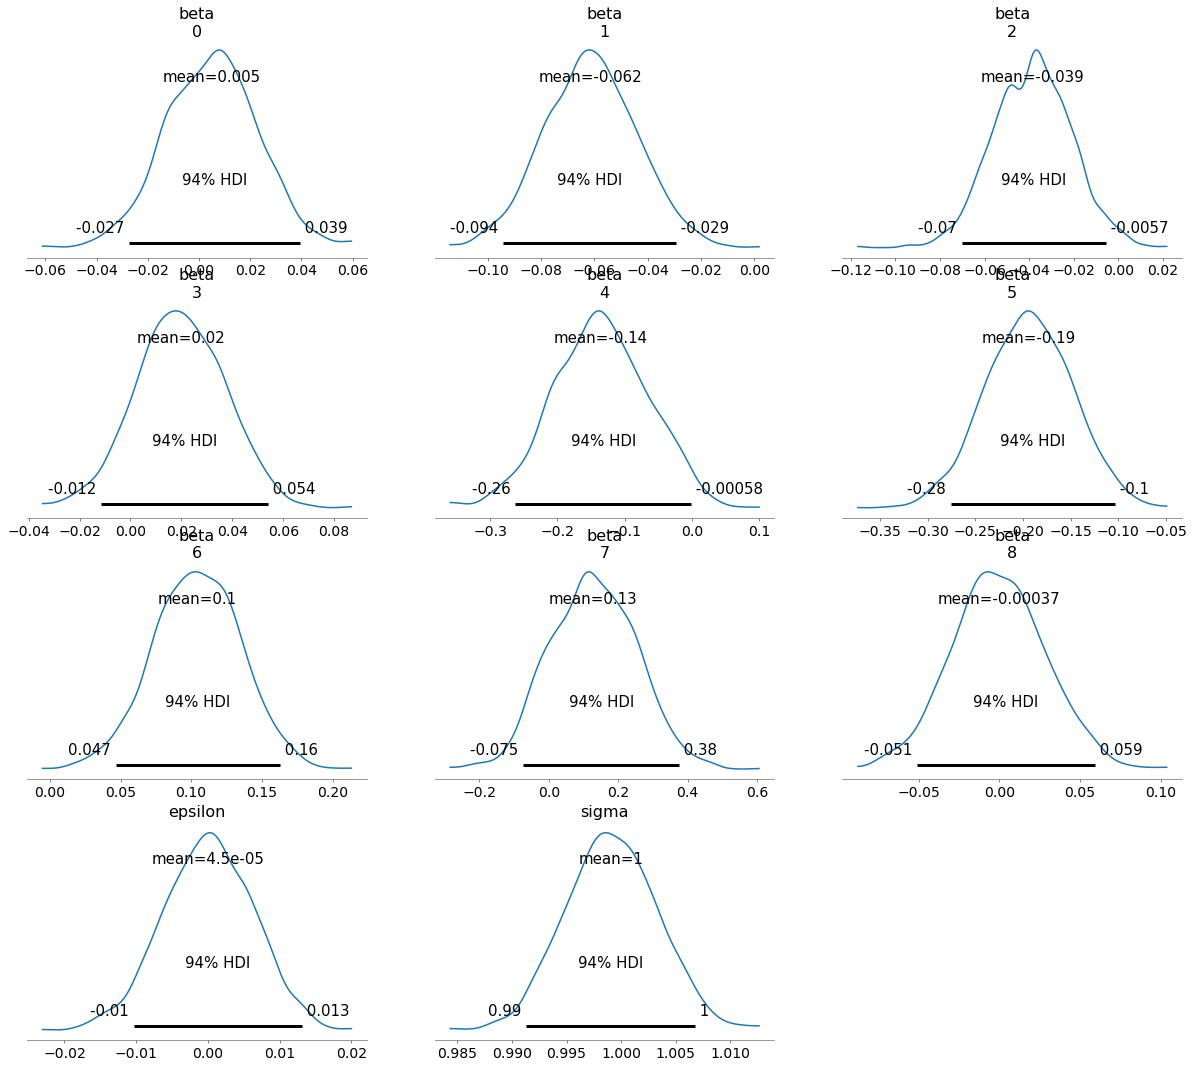

In [20]:
with basic_model:
    az.plot_posterior(trace)

## Prediction using the Bayesian Model

In [21]:
# getting the mean values of the parameters as estimates:

var_weights = {}
var_summary = pm.summary(trace)
var_weights['intercept'] = var_summary['mean']['epsilon']
for i, c in enumerate(cols):
    var_weights[c] = var_summary['mean']['beta['+str(i)+']']
var_weights = pd.DataFrame(var_weights, index=[0])

# storing the standard deviation -> useful for plotting prediction distribution
sd = trace['sigma'].mean()

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/omidbazgir/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [24]:
# preparing test set input for bayesian LR:
# note that: the input is the same as before, but I am explicitly adding the intercept column with constant '1'
# (in sklearn, the intercept is added by default, and used during both training and inference)

bayes_test_set_scaled = np.append(np.ones((len(test_set_scaled), 1)), test_set_scaled, axis=1)
bayes_test_set_prediction_scaled = np.dot(bayes_test_set_scaled, np.array(var_weights).T)
bayes_test_set_prediction = scalar_y.inverse_transform(bayes_test_set_prediction_scaled)


bayes_predicted_df = pd.DataFrame(np.array([['Midtown'], ['East Harlem'], ['Chinatown'], ['Upper West Side'], ['NoHo']]), columns = ['neighbourhood_group'])
bayes_predicted_df['bayes_price'] = bayes_test_set_prediction
bayes_predicted_df

,neighbourhood_group,bayes_price
0,Midtown,318.170630
1,East Harlem,206.471810
2,Chinatown,228.211848
3,Upper West Side,279.188491
4,NoHo,327.166508


In [49]:
def test_prediction(var_weights, sd, test_observation, scalar_y, train_val=None, show_ols=False):

    # Ordinary LR output:
    #test_observation = np.array(test_observation)
    #test_observation = test_observation.reshape(1,-1)
    #ols_output = reg.predict(test_observation)
    #ols_output = scalar_y.inverse_transform(ols_output)

    # Bayesian output:
    test_observation = test_observation
    intercept = np.array([1])
    test_observation = np.concatenate((intercept, test_observation))

    prediction_mean = np.dot(test_observation, np.array(var_weights).T)
    prediction_mean = prediction_mean.reshape(1,-1)
    prediction_mean = scalar_y.inverse_transform(prediction_mean)[0][0]

    # Plot the OLS estimate
    plt.figure(figsize=(10, 5))
    if show_ols:
        plt.vlines(x = ols_output, ymin = 0, ymax = 0.5, 
                    linestyles = '-', colors = 'orange',
                    label = 'OLS prediction',
                  linewidth = 2.5)

    # plot the bayesian output distribution
    estimates = np.random.normal(loc = prediction_mean, scale = sd, size = 1000)

    sns.distplot(estimates, hist = True, kde = True, bins = 19,
                hist_kws = {'edgecolor': 'k', 'color': 'orange'},
              kde_kws = {'linewidth' : 4},
              label = 'Bayesian - Estimated Dist.')

    # summary stats:
    plt.legend(loc=1)
    plt.xlabel('$ price')
    #print('OLS estimate = %0.4f' % ols_output)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                      np.percentile(estimates, 95)))
    # return estimates

/Users/omidbazgir/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


5% Estimate = 226.6550    95% Estimate = 229.8791


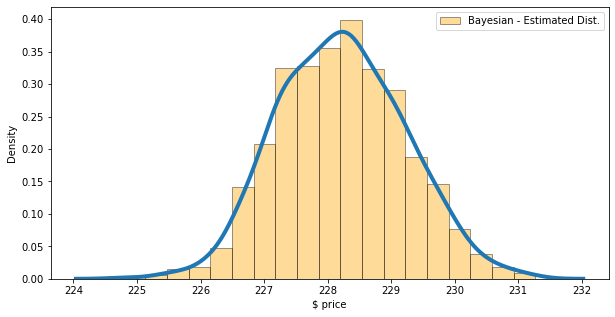

In [50]:
test_prediction(var_weights, sd, test_set_scaled.iloc[2], scalar_y,None, False)

# Bayesian Learning with Numpy
1) https://cosmiccoding.com.au/tutorials/bayes_lin_reg
2) https://emcee.readthedocs.io/en/latest/